In [ ]:
from google.colab import drive # Mounte personal Gdrive folder
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gdal rasterio geopandas numpy matplotlib

In [ ]:
# Import necessary modules
import os
import sys
import json
import numpy as np
import geopandas as gpd
import folium
import rasterio as rio
from rasterio.plot import show
from rasterio.io import MemoryFile
from rasterio.mask import mask
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Add project-specific path
sys.path.append("/content/drive/MyDrive/GP_Project")

# *STEP 1: Data Import and Parameter Settings*

### *I. Define Paths and Parameters*

In [ ]:
# File paths
raster_paths = {
    "B3": "/content/drive/MyDrive/GP_Project/test_data/B03.tif",
    "B4": "/content/drive/MyDrive/GP_Project/test_data/B04.tif",
    "B8": "/content/drive/MyDrive/GP_Project/test_data/B08.tif",
    "dtm": "/content/drive/MyDrive/GP_Project/test_data/DTM.tif"
}

roi_path = "/content/drive/MyDrive/GP_Project/test_data/roi.gpkg"

# Threshold settings
ndvi_threshold = 0.3
ndwi_threshold = 0.1
min_elevation_threshold = 0
max_elevation_threshold = 2500
max_slope_threshold = 15

# Filter out small areas (square meters)
min_area_threshold = 10000

# Define output directory path
output_path = '/content/drive/MyDrive/GP_Project'


### *II. Open Files*  

In [ ]:
# Open all raster data
rasters = {}
for name, path in raster_paths.items():
    rasters[name] = rio.open(path)

# Open ROI file
roi = gpd.read_file(roi_path)

print("All file loaded successfully.")


All file loaded successfully.


# *STEP 2: Data Processing*

### *I. Reproject*  

In [ ]:
from data_processing import reproject_raster

# Get reference coordinate system
ref_crs = roi.estimate_utm_crs()

# Store reprojected data
reprojected_rasters = {raster_name: reproject_raster(raster, ref_crs) for raster_name, raster in rasters.items()}

# Reproject ROI if necessary
if roi.crs != ref_crs:
    roi = roi.to_crs(ref_crs)

# Print completion message
print("Reprojection of all rasters and ROI completed.")


Reprojection of all rasters and ROI completed.


### *II. Clip*  

In [ ]:
from data_processing import clip_raster

# Store clipped data
clipped_rasters = {raster_name: clip_raster(raster_data, roi) for raster_name, raster_data in reprojected_rasters.items()}

print("Clipping of all rasters completed.")


Clipping of all rasters completed.


### *III. Resample*

In [ ]:
from data_processing import resample_raster

# Resample all rasters to the target resolution
target_resolution = (20, 20)
resampled_rasters = {
    raster_name: resample_raster(raster_data, target_resolution)
    for raster_name, raster_data in clipped_rasters.items()
}

print("Resampling of all rasters completed.")

Resampling of all rasters completed.


### *IV. Align Raster Shapes*  

In [ ]:
def align_shapes_in_rasters(rasters_dict):
    min_rows = min(raster["data"].shape[0] for raster in rasters_dict.values())
    min_cols = min(raster["data"].shape[1] for raster in rasters_dict.values())

    for key, raster in rasters_dict.items():
        rasters_dict[key]["data"] = raster["data"][:min_rows, :min_cols]

align_shapes_in_rasters(resampled_rasters)
print("Shapes of all resampled rasters have been aligned.")

Shapes of all resampled rasters have been aligned.


# *STEP 3: Data Analysis*

### *I. NDVI*  


<ipython-input-16-ba61467e8228>:6: RuntimeWarning: invalid value encountered in divide
  ndvi = (b8_data - b4_data) / (b8_data + b4_data)


NDVI range (processed): -0.1774241179227829 - 0.5591615438461304


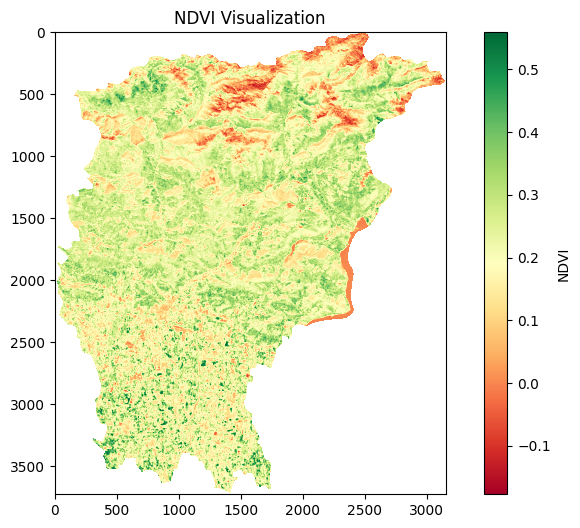

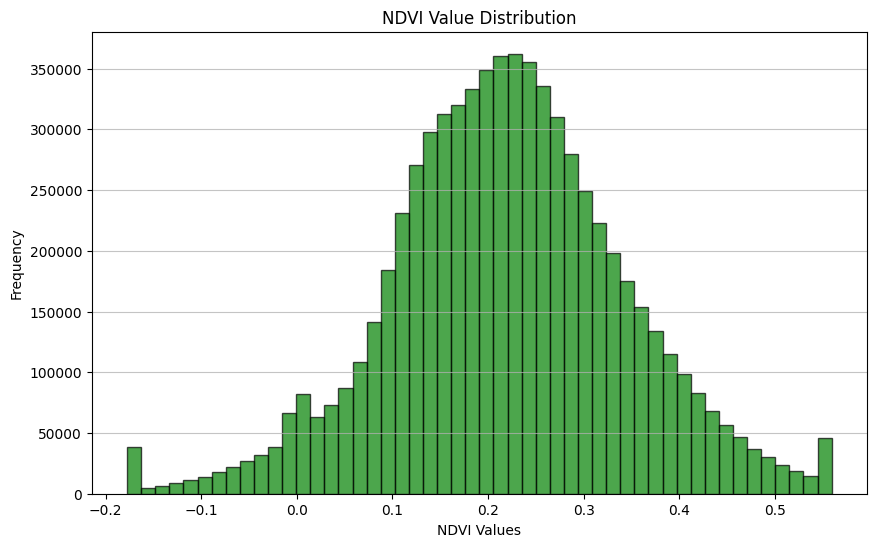

In [ ]:
# Retrieve resampled B8 and B4 data
b8_data = resampled_rasters["B8"]["data"]
b4_data = resampled_rasters["B4"]["data"]

# Calculate NDVI with zero-division handling
ndvi = (b8_data - b4_data) / (b8_data + b4_data)
ndvi = np.where((b8_data + b4_data) == 0, np.nan, ndvi)

# Define NDVI quantile range
lower_bound = np.nanpercentile(ndvi, 0.5)
upper_bound = np.nanpercentile(ndvi, 99.5)

# Process NDVI outliers
ndvi_data = np.copy(ndvi)
ndvi_data[(ndvi < lower_bound) | (ndvi > upper_bound)] = np.clip(
    ndvi[(ndvi < lower_bound) | (ndvi > upper_bound)], lower_bound, upper_bound
)

# Check NDVI data range
ndvi_min, ndvi_max = np.nanmin(ndvi_data), np.nanmax(ndvi_data)
print(f"NDVI range (processed): {ndvi_min} - {ndvi_max}")

# Visualize NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_data, cmap="RdYlGn", vmin=ndvi_min, vmax=ndvi_max)
plt.colorbar(label="NDVI")
plt.title("NDVI Visualization")
plt.show()

# Plot NDVI value distribution
plt.figure(figsize=(10, 6))
plt.hist(
    ndvi_data[~np.isnan(ndvi_data)].flatten(),
    bins=50, color="green", alpha=0.7, edgecolor="black"
)
plt.title("NDVI Value Distribution")
plt.xlabel("NDVI Values")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()


### *II. NDWI*  

<ipython-input-17-e5bb9c4f312e>:6: RuntimeWarning: invalid value encountered in divide
  ndwi = (b3_data - b8_data) / (b3_data + b8_data)


NDWI range (processed): -0.5525224208831787 - 0.2107737809419632


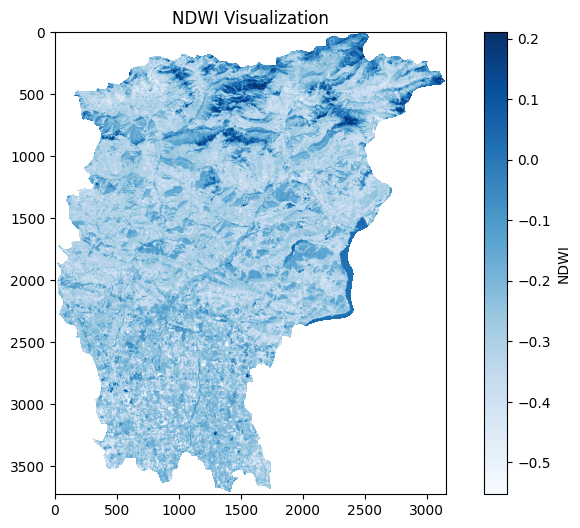

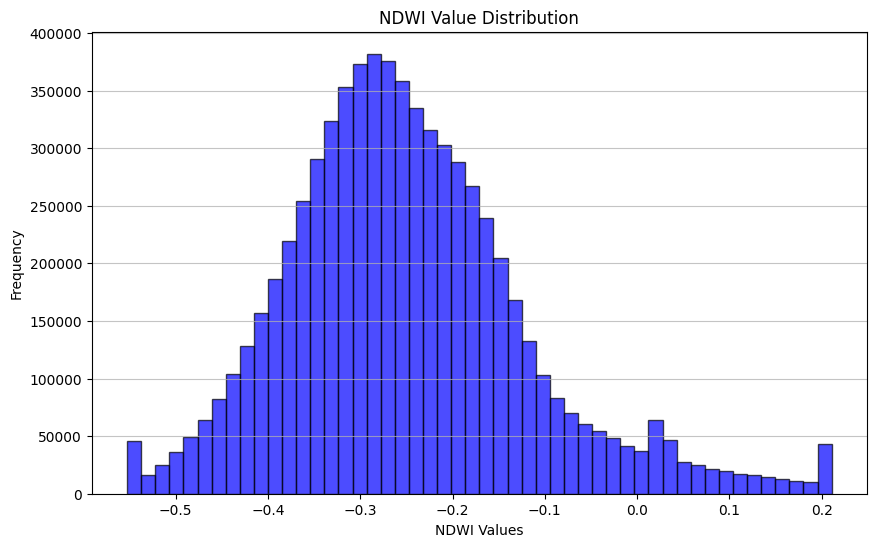

In [ ]:
# Retrieve resampled B3 and B8 data
b3_data = resampled_rasters["B3"]["data"]
b8_data = resampled_rasters["B8"]["data"]

# Calculate NDWI with zero-division handling
ndwi = (b3_data - b8_data) / (b3_data + b8_data)
ndwi = np.where((b3_data + b8_data) == 0, np.nan, ndwi)

# Define NDWI quantile range
lower_bound = np.nanpercentile(ndwi, 0.5)
upper_bound = np.nanpercentile(ndwi, 99.5)

# Process NDWI outliers
ndwi_data = np.copy(ndwi)
ndwi_data[(ndwi < lower_bound) | (ndwi > upper_bound)] = np.clip(
    ndwi[(ndwi < lower_bound) | (ndwi > upper_bound)], lower_bound, upper_bound
)

# Check NDWI data range
ndwi_min, ndwi_max = np.nanmin(ndwi_data), np.nanmax(ndwi_data)
print(f"NDWI range (processed): {ndwi_min} - {ndwi_max}")

# Visualize NDWI
plt.figure(figsize=(10, 6))
plt.imshow(ndwi_data, cmap="Blues", vmin=ndwi_min, vmax=ndwi_max)
plt.colorbar(label="NDWI")
plt.title("NDWI Visualization")
plt.show()

# Plot NDWI value distribution
plt.figure(figsize=(10, 6))
plt.hist(
    ndwi_data[~np.isnan(ndwi_data)].flatten(),
    bins=50, color="blue", alpha=0.7, edgecolor="black"
)
plt.title("NDWI Value Distribution")
plt.xlabel("NDWI Values")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()


### *III. DTM*  

DTM range: 14.0 - 3040.0


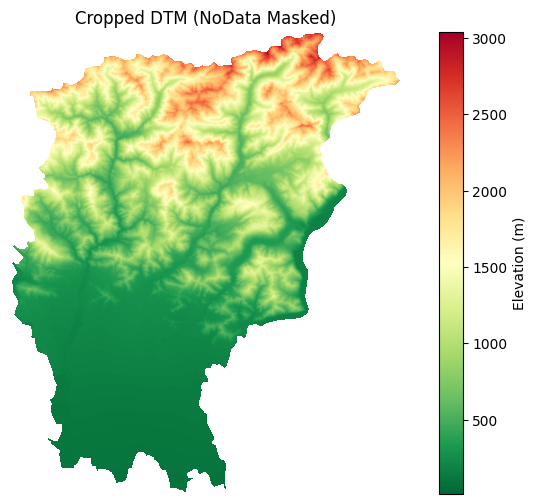

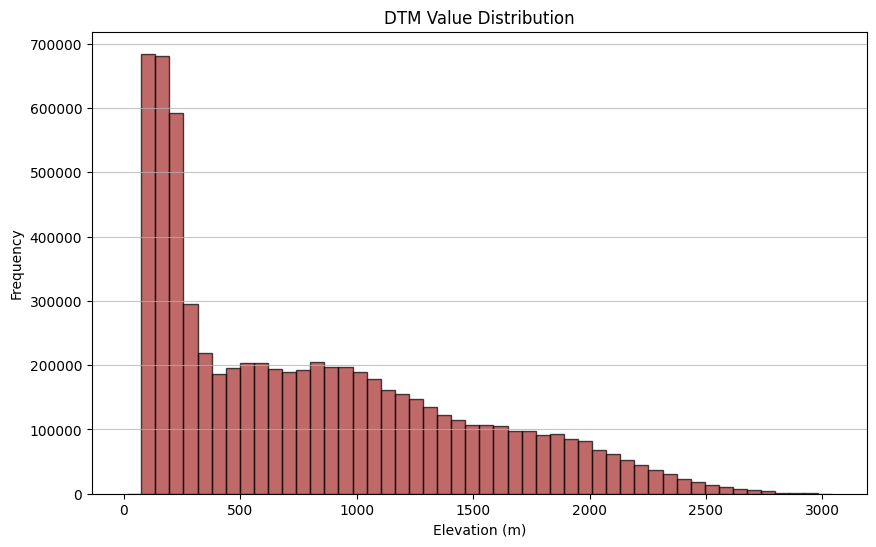

In [ ]:
# Retrieve cropped DTM data
dtm_data = resampled_rasters["dtm"]["data"]

# Mask NoData values
nodata_value = 0
dtm_data = np.where(dtm_data == nodata_value, np.nan, dtm_data)

# Check data range
dtm_min, dtm_max = np.nanmin(dtm_data), np.nanmax(dtm_data)
print(f"DTM range: {dtm_min} - {dtm_max}")

# Visualize DTM data
plt.figure(figsize=(10, 6))
plt.title("Cropped DTM (NoData Masked)")
plt.imshow(dtm_data, cmap="RdYlGn_r", origin="upper", vmin=dtm_min, vmax=dtm_max)
plt.colorbar(label="Elevation (m)")
plt.axis("off")
plt.show()

# Plot DTM value distribution
plt.figure(figsize=(10, 6))
plt.hist(
    dtm_data[~np.isnan(dtm_data)].flatten(),
    bins=50, color="brown", alpha=0.7, edgecolor="black"
)
plt.title("DTM Value Distribution")
plt.xlabel("Elevation (m)")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()


### *IV. Slope*  


Slope range: 0.0 - 89.65234344615699


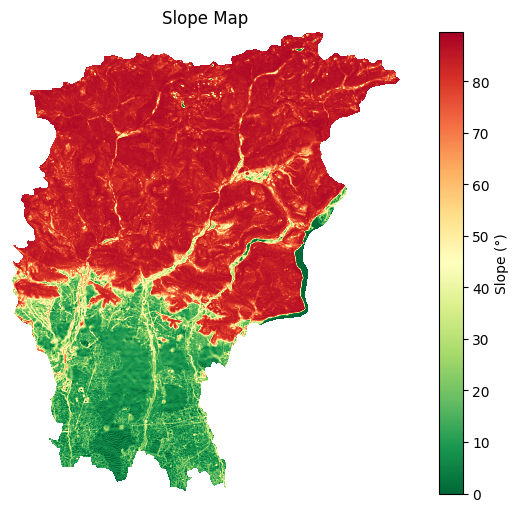

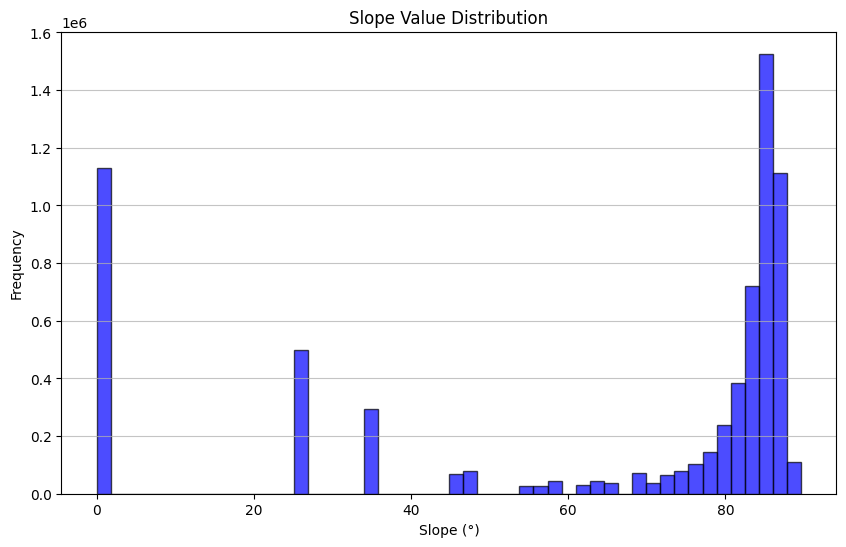

In [ ]:
# Generate slope map
x, y = np.gradient(dtm_data)
slope_rate = np.sqrt(x**2 + y**2)  # Slope as rate of change
slope_data = np.arctan(slope_rate) * (180 / np.pi)  # Convert to degrees

# Check slope value range
slope_min, slope_max = np.nanmin(slope_data), np.nanmax(slope_data)
print(f"Slope range: {slope_min} - {slope_max}")

# Visualize slope map
plt.figure(figsize=(10, 6))
plt.title("Slope Map")
plt.imshow(slope_data, cmap="RdYlGn_r", origin="upper", vmin=slope_min, vmax=slope_max)
plt.colorbar(label="Slope (°)")
plt.axis("off")
plt.show()

# Plot slope value distribution
plt.figure(figsize=(10, 6))
plt.hist(
    slope_data[~np.isnan(slope_data)].flatten(),
    bins=50, color="blue", alpha=0.7, edgecolor="black"
)
plt.title("Slope Value Distribution")
plt.xlabel("Slope (°)")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.show()

# *STEP 4: Buildable Area Selection*


### *I. Get Mask*

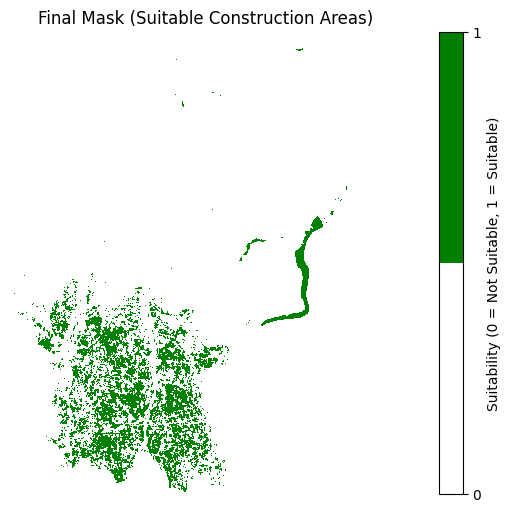

In [ ]:
# Define filter functions
def filter_vegetation(ndvi_image, threshold):
    return ndvi_image <= threshold

def filter_water(ndwi_image, threshold):
    return ndwi_image <= threshold

def filter_elevation(elevation_image, min_elevation, max_elevation):
    return (elevation_image >= min_elevation) & (elevation_image <= max_elevation)

def filter_slope(slope_image, max_slope):
    return slope_image <= max_slope

# Apply filters
vegetation_mask = filter_vegetation(ndvi_data, ndvi_threshold)
water_mask = filter_water(ndwi_data, ndwi_threshold)
elevation_mask = filter_elevation(dtm_data, min_elevation_threshold, max_elevation_threshold)
slope_mask = filter_slope(slope_data, max_slope_threshold)

# Combine all masks
combined_mask = vegetation_mask & water_mask & elevation_mask & slope_mask

# Create custom colormap
cmap = ListedColormap(["white", "green"])

plt.figure(figsize=(10, 6))
plt.title("Final Mask (Suitable Construction Areas)")
plt.imshow(combined_mask, cmap=cmap)
plt.colorbar(ticks=[0, 1], label="Suitability (0 = Not Suitable, 1 = Suitable)")
plt.axis("off")
plt.show()


### *II. Vectorization*  

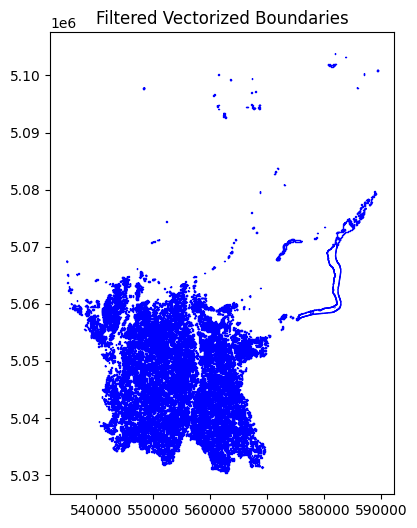

Statistics for filtered areas:
Maximum Area (m²): 16298400.0
Minimum Area (m²): 10000.0
Number of Regions: 5942
Total Area (m²): 283656800.0


In [ ]:
# Vectorize combined_mask
mask_shapes = shapes(combined_mask.astype("uint8"), transform=resampled_rasters["dtm"]["transform"])
geometries = [shape(geom) for geom, value in mask_shapes if value == 1]

# Create GeoDataFrame
gdf = gpd.GeoDataFrame({'geometry': geometries}, crs=resampled_rasters["dtm"]["crs"])

# Convert to UTM coordinate system
utm_crs = gdf.estimate_utm_crs()
gdf = gdf.to_crs(utm_crs)

# Calculate area for each polygon (in square meters)
gdf['area'] = gdf['geometry'].area

# Filter polygons with area >= 10,000 square meters
min_area_threshold = 10000
filtered_gdf = gdf[gdf['area'] >= min_area_threshold]

# Plot filtered vectorized boundaries
fig, ax = plt.subplots(figsize=(10, 6))
filtered_gdf.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=1)
ax.set_title("Filtered Vectorized Boundaries")
plt.show()

# Output statistics for filtered areas
area_stats = {
    'Maximum Area (m²)': filtered_gdf['area'].max(),
    'Minimum Area (m²)': filtered_gdf['area'].min(),
    'Number of Regions': len(filtered_gdf),
    'Total Area (m²)': filtered_gdf['area'].sum()
}

print("Statistics for filtered areas:")
for stat, value in area_stats.items():
    print(f"{stat}: {value}")


### *III. Save building_area file*  

In [ ]:
# Create output directory and file path
output_dir = os.path.join(output_path, "output")
output_file = os.path.join(output_dir, "building_area.geojson")

# Check and create output directory
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save GeoDataFrame as GeoJSON file
filtered_gdf.to_file(output_file, driver="GeoJSON")
print(f"Data saved to: {output_file}")

NameError: name 'os' is not defined

# *STEP 5:Dashboard*  

### *I. Prepare Map Layers*  

In [ ]:
# Check and convert ROI CRS to EPSG:4326
if roi.crs.to_string() != "EPSG:4326":
    roi = roi.to_crs("EPSG:4326")

# Load GeoJSON data as GeoDataFrame
gdf = gpd.read_file(output_file)

# Convert GeoDataFrame CRS to EPSG:4326 if necessary
if gdf.crs.to_string() != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Convert GeoDataFrame to GeoJSON data
geojson_data = json.loads(gdf.to_json())

# Calculate map center coordinates
center_lat, center_lon = roi.geometry.centroid.y.mean(), roi.geometry.centroid.x.mean()

# Create Folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=9)

# Add ROI to map
folium.GeoJson(
    data=json.loads(roi.to_json()),
    name="ROI",
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': 'red',
        'weight': 2
    }
).add_to(m)

# Add GeoJSON data to map
folium.GeoJson(
    geojson_data,
    name="Suitable Building Areas",
    style_function=lambda feature: {
        'fillColor': 'green',
        'color': 'blue',
        'weight': 1,
        'fillOpacity': 0.4
    }
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

<ipython-input-23-e323f49f4f4b>:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_lat, center_lon = roi.geometry.centroid.y.mean(), roi.geometry.centroid.x.mean()


### *II. Map*

In [ ]:
m